In [ ]:
# Importing libraries and modules
import Pkg; Pkg.activate(@__DIR__)
using Pkg; Pkg.instantiate()
using DifferentialEquations, LinearAlgebra, Statistics, Random
using Plots, Distributions, KernelDensity, StatsBase

### Elementary Reaction Kinetics

In [17]:
# Parameters
p = (0.5, 0.5, 0.5)  # k1, k2, σ
u0 = [2.0, 0.0, 0.0]  # Initial concentrations of X, Y, Z
T = 60.0
dt = 0.05
N = Int(T/dt)
M = 50_000  # number of trajectories
tspan = (0.0, T)
tsteps = 0:dt:T

# Define drift and diffusion for the components
function f!(du, u, p, t)
    X, Y, Z = u
    k1, k2 = p
    du[1] = -k1 * X
    du[2] = k1 * X - k2 * Y
    du[3] = k2 * Y
end

function g!(du, u, p, t)
    X, Y, Z = u
    σ = p[3]
    du[1] = 0
    du[2] = σ * Y
    du[3] = 0
end

# Laguerre basis functions up to degree 3
function laguerre_design_matrix(y::Vector{Float64}, d::Int)
    Φ = zeros(length(y), d + 1)
    for i in 1:length(y)
        Φ[i,1] = 1.0
        if d >= 1
            Φ[i,2] = 1 - y[i]
        end
        if d >= 2
            Φ[i,3] = 1 - 2*y[i] + 0.5*y[i]^2
        end
        if d >= 3
            Φ[i,4] = 1 - 3*y[i] + 1.5*y[i]^2 - (1/6)*y[i]^3
        end
    end
    return Φ
end

laguerre_design_matrix (generic function with 1 method)

### Longstaff-Schwartz Algorithm

In [18]:
# Store all trajectories
Xs = zeros(M, length(tsteps))
Ys = zeros(M, length(tsteps))

# Store stopping times
τ = fill(length(tsteps), M)

# Simulate all trajectories
prob = SDEProblem(f!, g!, u0, tspan, p)
Random.seed!(42)
for i in 1:M
    sol = solve(prob, EM(), dt=dt, saveat=tsteps)
    Xs[i, :] .= sol[1,:]
    Ys[i, :] .= sol[2,:]
end

# Initialize matrices for Longstaff-Schwartz
V = copy(Ys) # copy(Xs) if we're using Xs
degree = 3  # Degree of polynomial basis
β_matrix = zeros(N, degree + 1)

# Longstaff-Schwartz backward induction in time
for n in (length(tsteps)-1):-1:2
    y_now = Ys[:, n]
    value_future = V[:, n+1]

    # Optional: Filter out non-positive values (in-the-money paths for options)
    # all of the values are supposed to be positive
    itm_indices = findall(y -> y > 0, y_now)
    if length(itm_indices) < 10
        continue
    end

    y_itm = y_now[itm_indices]
    vf_itm = value_future[itm_indices]

    # Fit polynomial regression using Laguerre basis functions
    Φ = laguerre_design_matrix(y_itm, degree)
    β = Φ \ vf_itm
    
    # Compute continuation value
    # Note: This is where the polynomial regression is used to compute the continuation value
    continuation_value = Φ * β
    stop_now = y_itm .> continuation_value

    # Update stopping times
    # Note: This is where we update the stopping times based on the stopping condition
    for (idx, stop) in zip(itm_indices, stop_now)
        if stop
            V[idx,n] = y_now[idx]
            τ[idx] = min(τ[idx], n)
        else
            V[idx,n] = V[idx,n+1]
        end
    end

    # Save regression coefficients
    β_matrix[n, :] .= β

end

# Compile outputs
Y_opt_values = [Ys[i, τ[i]] for i in 1:M]
τ_times = [tsteps[τ[i]] for i in 1:M]

50000-element Vector{Float64}:
 1.55
 1.95
 1.8
 1.75
 1.05
 1.3
 2.95
 1.75
 3.8
 1.5
 ⋮
 2.3
 2.35
 2.85
 1.6
 1.5
 1.9
 1.6
 2.65
 4.8

### Results

Estimated optimal expected value of Y: 0.7964
Expected optimal stopping time: 2.5101 seconds
Variance of stopping time: 1.0195 seconds^2
Standard deviation of stopping time: 1.0097 seconds
95% confidence interval for stopping time: 1.25 to 4.8 seconds
95% confidence interval for expected value of Y: 0.1637 to 1.321


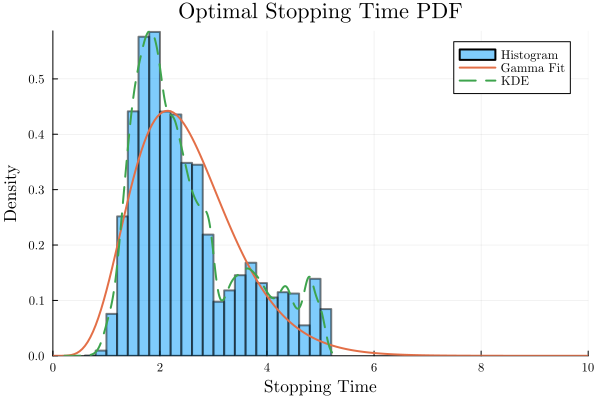

In [19]:
println("Estimated optimal expected value of Y: ", round(mean(Y_opt_values), digits=4))
println("Expected optimal stopping time: ", round(mean(τ_times), digits=4), " seconds")
println("Variance of stopping time: ", round(var(τ_times), digits=4), " seconds^2")
println("Standard deviation of stopping time: ", round(std(τ_times), digits=4), " seconds")
println("95% confidence interval for stopping time: ", round(quantile(τ_times, 0.025), digits=4), " to ", round(quantile(τ_times, 0.975), digits=4), " seconds")
println("95% confidence interval for expected value of Y: ", round(quantile(Y_opt_values, 0.025), digits=4), " to ", round(quantile(Y_opt_values, 0.975), digits=4))

# Plot: Histogram + Gamma fit + KDE
histogram(τ_times, bins=30, normalize=true, label="Histogram", xlabel="Stopping Time", ylabel="Density", title="Optimal Stopping Time PDF", 
          legend=:topright, fontfamily="Computer Modern", lw=2, alpha=0.5)

# Gamma distribution fit
fit_gamma = fit(Gamma, τ_times)
plot!(tsteps, pdf.(fit_gamma, tsteps), lw=2, label="Gamma Fit")

# KDE overlay
kde_est = kde(τ_times)
plot!(kde_est.x, kde_est.density, lw=2, linestyle=:dash, label="KDE")

xlims!(0, 10)

In [20]:
# # Setting up the model parameters
# # The parameters are defined in a dictionary for easy access and modification
# params = Dict(
#     "k1" => 0.5,  # Rate constant for X
#     "k2" => 0.5,  # Rate constant for Y
#     "σ" => 0.25,    # Noise scaling parameter
#     "K_sy" => 0.25  # Saturation constant for Y
# )

# # Initial conditions for the state variables
# # The initial conditions are defined in a dictionary for easy access and modification
# init = Dict(
#     "X0" => 10.0, 
#     "Y0" => 0.0, 
#     "Z0" => 0.0
# )

# # Time parameters
# T = 25.0  # Time span for the simulation
# dt = 0.01  # Time step for the simulation
# tsteps = 0:dt:T  # Time steps array
# N = length(tsteps)  # Number of time steps

# # Running the Monte Carlo simulation
# M = 1_000  # Number of Monte Carlo simulations
# noise = "noise" # Type of noise for the SDEs ("noise" or "monod")
# sdesol = simulate_paths(params, T, init, M, noise, dt)[1]
# odesol = simulate_paths(params, T, init, M, noise, dt)[2]
# time = odesol.t  # Time vector from the ODE solution

# # Storing the results in matrices for each state variable
# X = zeros(length(sdesol), length(sdesol[1].t))
# Y = zeros(length(sdesol), length(sdesol[1].t))
# Z = zeros(length(sdesol), length(sdesol[1].t))

# for i in 1:length(sdesol)
#     X[i, :] = sdesol[i][1, :]
#     Y[i, :] = sdesol[i][2, :]
#     Z[i, :] = sdesol[i][3, :]
# end

In [21]:
# # Plotting the results
# using LaTeXStrings
# plot(sdesol[50], title="SDE Reaction Simulation", label=[L"Reactant (X_{SDE})" L"Product (Y_{SDE})" L"Byproduct (Z_{SDE})"], xlabel="Time (h)", ylabel="Concentration (g/L)")
# plot!(odesol, title="SDE Reaction Simulation", label=[L"Reactant (X_{ODE})" L"Product (Y_{ODE})" L"Byproduct (Z_{ODE})"], xlabel="Time (h)", ylabel="Concentration (g/L)", lines=:dash)
# plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["X0"]), xlims=(0, T))

In [22]:
# # Store stopping times
# τ = fill(length(tsteps), M)

# # Initialize matrices for Longstaff-Schwartz
# V = copy(Y) # copy(Xs) if we're using Xs
# degree = 3  # Degree of polynomial basis
# β_matrix = zeros(N, degree + 1)

# # Longstaff-Schwartz backward induction in time
# for n in (length(tsteps)-1):-1:2
#     y_now = Y[:, n]
#     value_future = V[:, n+1]

#     # Optional: Filter out non-positive values (in-the-money paths for options)
#     # all of the values are supposed to be positive
#     itm_indices = findall(y -> y > 0, y_now)
#     if length(itm_indices) < 10
#         continue
#     end

#     y_itm = y_now[itm_indices]
#     vf_itm = value_future[itm_indices]

#     # Fit polynomial regression using Laguerre basis functions
#     Φ = laguerre_design_matrix(y_itm, degree)
#     β = Φ \ vf_itm
    
#     # Compute continuation value
#     # Note: This is where the polynomial regression is used to compute the continuation value
#     continuation_value = Φ * β
#     stop_now = y_itm .> continuation_value

#     # Update stopping times
#     # Note: This is where we update the stopping times based on the stopping condition
#     for (idx, stop) in zip(itm_indices, stop_now)
#         if stop
#             V[idx,n] = y_now[idx]
#             τ[idx] = min(τ[idx], n)
#         else
#             V[idx,n] = V[idx,n+1]
#         end
#     end

#     # Save regression coefficients
#     β_matrix[n, :] .= β

# end

# # Compile and plot outputs
# Y_opt_values = [Y[i, τ[i]] for i in 1:M]
# τ_times = [tsteps[τ[i]] for i in 1:M]

In [23]:
# # Plotting the results
# println("Estimated optimal expected value of Y: ", round(mean(Y_opt_values), digits=4), " g/L")
# println("Expected optimal stopping time: ", round(mean(τ_times), digits=4), " h")
# println("95% confidence interval for stopping time: ", round(quantile(τ_times, 0.025), digits=4), " to ", round(quantile(τ_times, 0.975), digits=4), " h")
# println("95% confidence interval for expected value of Y: ", round(quantile(Y_opt_values, 0.025), digits=4), " to ", round(quantile(Y_opt_values, 0.975), digits=4))
# histogram(τ_times, bins=50, title="Distribution of Optimal Stopping Times", xlabel="Optimal Stopping Time", ylabel="Frequency", legend=false)
# plot!(xlabel="Optimal Stopping Time", ylabel="Frequency", title="Distribution of Optimal Stopping Time", legend=false, grid=true)